In [1]:
#%pip freeze > requirements.txt


In [2]:
#liberar memoria de la GPU  
#from numba import cuda
#cuda.select_device(0)
##cuda.select_device(1)
#cuda.close()
#from tensorflow.keras import backend as K
#K.clear_session()
#liberar memoria de la RAM
#import gc
#gc.collect()


In [4]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2023-11-30 11:49:21.273311: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-30 11:49:24.462274: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-11-30 11:49:24.462397: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-11-30 11:49:24.462405: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

Num GPUs Available:  2


2023-11-30 11:49:26.779588: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:26.783071: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:27.168549: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:27.171383: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-30 11:49:27.174082: I tensorflow/compiler/xla/stream_executo

## Librerias y cargar dataset

In [3]:
import tensorflow as tf
from tensorflow import keras
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
#from google.colab import files
import zipfile

2023-12-01 10:06:11.172694: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-01 10:06:11.852080: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-12-01 10:06:11.852125: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-12-01 10:06:11.852131: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

## Funciones

In [4]:
def create_shifted_frames_2(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, data.shape[1]-1, :, :]
    return x, y

#Toma todos los colores existentes en la imagen
def get_colors(image):
  aux = []
  band = True
  for i in image:
    for j in i:

      for k in aux:
        if j.tolist() == k:
          band = False
          break
      if band:
        aux.append(j.tolist())
      band = True
  return np.array(aux)

def balance_img_categories(img, palette, balancer):
  #palette = np.sort(palette)
  rows = len(img)
  cols = len(img[0])
  for i in range(rows):
    for j in range(cols):
      pos = np.where(palette == img[i,j])[0][0]
      img[i,j] = balancer[pos]
  return img


#Función para dada una paleta solo tomar los colores de esa paleta en la imagen
def quantizetopalette(silf, palette, dither=False, mode="P"):
  """Convert an RGB or L mode image to use a given P image's palette."""
  silf.load()
  palette.load()
  im = silf.im.convert(mode, 0, palette.im)
  # the 0 above means turn OFF dithering making solid colors
  return silf._new(im)

#Realiza las operaciones necesarias para obtener una imagen RGB por una paleta de colores
def rgb_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('P', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img).convert("RGB")
  newImage = quantizetopalette(oldImage,palImage)
  res_image = np.asarray(newImage.convert("RGB"))
  return res_image

def gray_quantized(img, palette):
  rows, cols = len(img), len(img[0])
  total_vals = 1
  for i in palette.shape:
    total_vals *= i
  palettedata = palette.reshape(total_vals).tolist()
  palImage = Image.new('L', (rows, cols))
  palImage.putpalette(palettedata*32)
  oldImage = Image.fromarray(img, 'L')
  newImage = quantizetopalette(oldImage,palImage, mode="L")
  res_image = np.asarray(newImage)
  return res_image

def recolor_greys_image(data, palette):
    rows, cols = len(data), len(data[0])
    aux = np.zeros((rows, cols), dtype=np.uint64)
    for i in range(rows):
        for j in range(cols):
            aux[i,j] = min(palette, key= lambda x:abs(x-data[i,j]))
    return aux


def agroup_window(data, window):
    new_data = [data[i:window+i] for i in range(len(data)-window+1)]
    return np.array(new_data)


def add_last(data, new_vals):
    print(f"data: {data.shape} y new_val: {new_vals.shape}")
    x_test_new = data[:,1:]
    print(f"x_test_new: {x_test_new.shape}")

    l = []
    for i in range(len(x_test_new)):
        l.append(np.append(x_test_new[i], new_vals[i]))
    x_test_new = np.array(l).reshape(data.shape[:])
    print("CX", x_test_new.shape)
    return x_test_new

def add_lastNew(data, new_val):
    print(f"data: {data.shape} y new_val: {new_val.shape}")
    x_test_new = data[:,1:,...]  # Omite el primer paso de tiempo
    print(f"x_test_new: {x_test_new.shape}")

    # Asumiendo que new_val es una única predicción que se debe añadir a cada paso de tiempo en x_test_new
    new_val = new_val.squeeze(axis=0)  # Elimina la dimensión del batch, si es necesario

    print(new_val.shape)
    # Añadir new_val a cada elemento en x_test_new
    x_test_new = np.concatenate((x_test_new, np.expand_dims(new_val, axis=1)), axis=1)

    print("CX", x_test_new.shape)
    return x_test_new


    #Crea cubos con su propia información de tamaño h
def get_cubes(data, h):
    new_data = []
    for i in range(0, len(data)-h):
        new_data.append(data[i:i+h])
    new_data = np.array(new_data)
    print(new_data.shape)
    return new_data

## Codigo

Variables iniciales para correr el codigo

In [57]:
rows = 61
cols = 180
channels = 1
window = 5
categories = [0, 35, 70, 119, 177, 220, 255] 
horizon = 4
parte0_0 = "Part0_0"
parte0_1 = "Part0_1"
parte1_0 = "Part1_0"
parte1_1 = "Part1_1"

In [6]:
#cargar el modelo
model0_0 = keras.models.load_model("DroughtDatasetMask/NPY61_180"+parte0_0+"/ConvLSTM2D_Mask61_180.h5")
model0_1 = keras.models.load_model("DroughtDatasetMask/NPY61_180"+parte0_1+"/ConvLSTM2D_Mask61_180.h5")
model1_0 = keras.models.load_model("DroughtDatasetMask/NPY61_180"+parte1_0+"/ConvLSTM2D_Mask61_180.h5")
model1_1 = keras.models.load_model("DroughtDatasetMask/NPY61_180"+parte1_1+"/ConvLSTM2D_Mask61_180.h5")

2023-12-01 10:24:47.770575: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-01 10:24:47.771096: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-01 10:24:47.775545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-01 10:24:47.776135: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-12-01 10:24:47.776546: I tensorflow/compiler/xla/stream_executo

In [107]:
#cargar xtest y ytest
x_test0_0 = np.load("DroughtDatasetMask/NPY61_180"+parte0_0+"/x_test_mask.npy")
y_test0_0 = np.load("DroughtDatasetMask/NPY61_180"+parte0_0+"/y_test_mask.npy")
x_test0_1 = np.load("DroughtDatasetMask/NPY61_180"+parte0_1+"/x_test_mask.npy")
y_test0_1 = np.load("DroughtDatasetMask/NPY61_180"+parte0_1+"/y_test_mask.npy")
x_test1_0 = np.load("DroughtDatasetMask/NPY61_180"+parte1_0+"/x_test_mask.npy")
y_test1_0 = np.load("DroughtDatasetMask/NPY61_180"+parte1_0+"/y_test_mask.npy")
x_test1_1 = np.load("DroughtDatasetMask/NPY61_180"+parte1_1+"/x_test_mask.npy")
y_test1_1 = np.load("DroughtDatasetMask/NPY61_180"+parte1_1+"/y_test_mask.npy")
print("xtest",x_test0_0.shape)

#merge xtest0_0 y xtest0_1
x_test0 = np.concatenate((x_test0_0, x_test0_1), axis=3)
x_test1 = np.concatenate((x_test1_0, x_test1_1), axis=3)
x_test = np.concatenate((x_test0, x_test1), axis=2)
print("xtest final",x_test.shape)

print("ytest",y_test0_0.shape)
#merge ytest0_0 y ytest0_1
y_test0 = np.concatenate((y_test0_0, y_test0_1), axis=2)
y_test1 = np.concatenate((y_test1_0, y_test1_1), axis=2)
y_test = np.concatenate((y_test0, y_test1), axis=1)
print("ytest final",y_test.shape)

xtest (371, 4, 61, 180, 1)
xtest final (371, 4, 122, 360, 1)
ytest (371, 61, 180, 1)
ytest final (371, 122, 360, 1)


In [84]:
print (f"lengeth x_test: {len(x_test)}")
imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
print(imagenInicial)

lengeth x_test: 371
82


(4, 61, 180, 1)
186/186 [==============================] - 3s 12ms/step - loss: 0.2718
El error del modelo es: 0.2718398869037628
186/186 [==============================] - 2s 11ms/step
(371, 61, 180, 1)
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
186/186 [==============================] - 2s 11ms/step
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
186/186 [==============================] - 2s 11ms/step
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
186/186 [==============================] - 2s 11ms/step
data: (371, 4, 61, 180, 1) y new_val: (371, 61, 180, 1)
x_test_new: (371, 3, 61, 180, 1)
CX (371, 4, 61, 180, 1)
PREDSS (371, 4, 61, 180, 1)
Preds (371, 61, 180, 1)
Preds2 (371, 61, 180, 1)
Preds3 (371, 61, 180, 1)
Preds4 (371, 61, 180, 1)
Res_forecast (371, 4, 61, 180, 1)
x_test (371, 4,

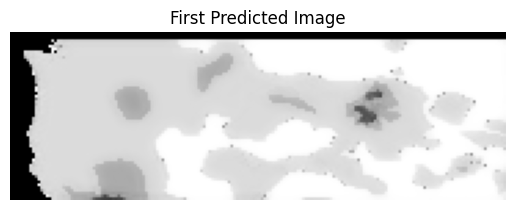

In [85]:
example = x_test[imagenInicial]

print(example.shape)

err = model.evaluate(x_test, y_test, batch_size= 2)
print("El error del modelo es: {}".format(err))
preds = model.predict(x_test, batch_size= 2)
print(preds.shape)
x_test_new = add_last(x_test, preds[:])
preds2 = model.predict(x_test_new, batch_size= 2)
#print(preds2.shape)
x_test_new = add_last(x_test_new, preds2[:])
preds3 = model.predict(x_test_new, batch_size= 2)
x_test_new = add_last(x_test_new, preds3[:])
preds4 = model.predict(x_test_new, batch_size= 2)
res_forecast = add_last(x_test_new, preds4[:])
print("PREDSS",res_forecast.shape)

np.save("DroughtDatasetMask/NPY61_180"+parte+"/PredictionsConvolutionLSTM_forecast_61_180_"+parte+"_w5.npy", res_forecast)  #Guardar el vector de predicciones

modelos = []
#agregar pred a modelos
modelos.append(preds)
modelos.append(preds2)
modelos.append(preds3)
modelos.append(preds4)


print("Preds" , preds.shape)
print("Preds2" , preds2.shape)
print("Preds3" , preds3.shape)
print("Preds4" , preds4.shape)
print("Res_forecast" , res_forecast.shape)
print("x_test" , x_test.shape)
print("x_test_new" , x_test_new.shape)
print("y_test" , y_test.shape)

# Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
plt.imshow(preds[0].squeeze(), cmap='gray')
plt.title("First Predicted Image")
plt.axis('off')
plt.show()



## Matriz de confusion


carga de datos para crear imagen completa y matriz de confusion


In [ ]:
#a

In [108]:
data0_0 = np.load("DroughtDatasetMask/NPY61_180"+parte0_0+"/PredictionsConvolutionLSTM_forecast_61_180_"+parte0_0+"_w5.npy")
data0_1 = np.load("DroughtDatasetMask/NPY61_180"+parte0_1+"/PredictionsConvolutionLSTM_forecast_61_180_"+parte0_1+"_w5.npy")
data1_0 = np.load("DroughtDatasetMask/NPY61_180"+parte1_0+"/PredictionsConvolutionLSTM_forecast_61_180_"+parte1_0+"_w5.npy")
data1_1 = np.load("DroughtDatasetMask/NPY61_180"+parte1_1+"/PredictionsConvolutionLSTM_forecast_61_180_"+parte1_1+"_w5.npy")
print(data0_0.shape)


(371, 4, 61, 180, 1)


(371, 4, 61, 360, 1)


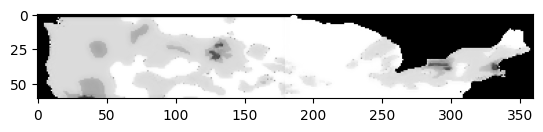

In [109]:
data_upper = np.concatenate((data0_0, data0_1), axis=3)
print(data_upper.shape)
plt.imshow(data_upper[0][0].squeeze(), cmap='gray')


(371, 4, 61, 360, 1)


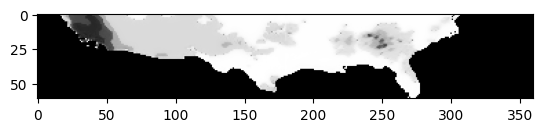

In [110]:
#pasar data0_0 y data0_1 a data_down en la forma de 371,4,122,180

data_down = np.concatenate((data1_0, data1_1), axis=3)
print(data_down.shape)
#mostrar la imagen de data_down
plt.imshow(data_down[0][0].squeeze(), cmap='gray')


(371, 4, 122, 360, 1)


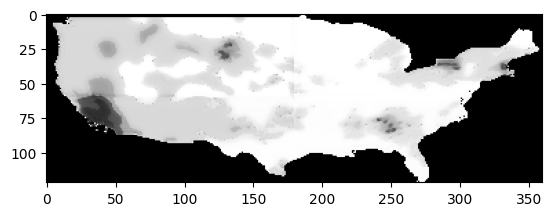

In [111]:
merged_data = np.concatenate((data_upper, data_down), axis=2)
print(merged_data.shape)
plt.imshow(merged_data[0][1].squeeze(), cmap='gray')

In [112]:
#guardar merged_data en un archivo .npy
np.save("DroughtDatasetMask/CompletaXpartes/merged_data_61_180_w5.npy", merged_data)  #Guardar el vector de predicciones

In [113]:
print("merged_data" , merged_data.shape)

merged_data (371, 4, 122, 360, 1)


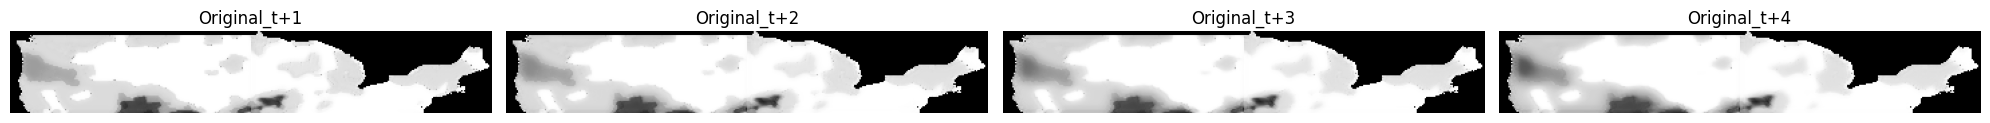

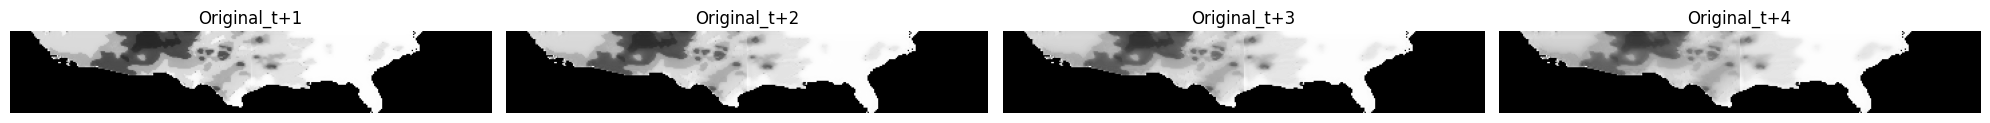

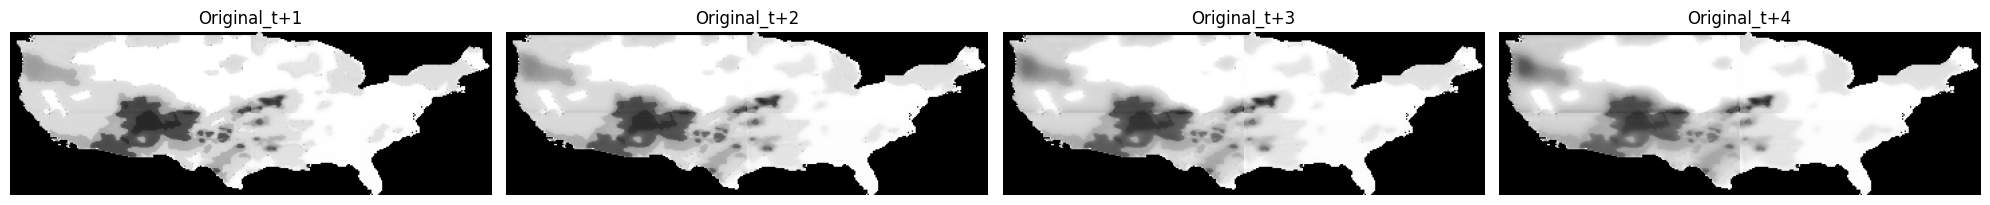

In [74]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100

for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(data_upper[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Original_t+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(20,20))
for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(data_down[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Original_t+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(20,20))
for i in range(horizon):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(merged_data[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Original_t+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()

In [114]:
classes = np.array([0, 255, 220, 177, 119, 70, 35]) # 255, 220, 177, 119, 70, 35  0
classes_rgb = np.array([[0,0,0], [35,35,35], [70,70,70], [119,119,119], [177,177,177], [220,220,220], [255,255,255]])
rows = len(x_test[0,0])
cols= len(x_test[0,0,0])
print(rows)
print(cols)
h = 4

122
360


In [115]:
print(merged_data.shape)
print(x_test.shape)
print(y_test.shape)

y_test = get_cubes(y_test, h)

(371, 4, 122, 360, 1)
(371, 4, 122, 360, 1)
(371, 122, 360, 1)
(367, 4, 122, 360, 1)


In [116]:
colors = get_colors(x_test[-10,0])
print("COLORSS", colors)
print("COLORS", colors.shape)

colorss = get_colors(merged_data[-10,0])
print("COLORSS", colorss)

COLORSS [[0.        ]
 [0.69411767]
 [0.86274511]
 [1.        ]
 [0.46666667]
 [0.27450982]
 [0.13725491]]
COLORS (7, 1)
COLORSS [[1.32879504e-05]
 [2.03774846e-07]
 [1.90176479e-07]
 ...
 [8.57009610e-08]
 [7.75794251e-06]
 [1.95570802e-03]]


In [118]:
print("new_merged_data",merged_data.shape)

new_merged_data (371, 4, 122, 360, 1)


In [119]:
naive = x_test[:-4]
merged_data = merged_data[1:-3]

#y_real = y_test[:, -h:]*255
new_merged_data = merged_data[:, -h:]
n_real = naive[:, -h:]*255

#y_test = y_test[:, -h:]
naive = naive[:, -h:]

In [120]:
print("XX")
print("y_test",y_test.shape)
print("new_merged_data",new_merged_data.shape)
print("n_real",n_real.shape)

print(min(new_merged_data[0,0,60]))
print(max(new_merged_data[0,0,60]))

XX
y_test (367, 4, 122, 360, 1)
new_merged_data (367, 4, 122, 360, 1)
n_real (367, 4, 122, 360, 1)
[3.6155816e-09]
[0.99715734]


In [121]:
new_merged_data = new_merged_data * 255
new_merged_data = new_merged_data.astype(np.uint8)

print("new_merged_data", new_merged_data.shape)
print(colorss.shape)
print(min(new_merged_data[0,0,60]))
print(max(new_merged_data[0,0,60]))

new_merged_data (367, 4, 122, 360, 1)
(34479, 1)
[0]
[254]


In [122]:

new_merged_data = new_merged_data.reshape(new_merged_data.shape[:-1])
print("HoY", new_merged_data.shape)

HoY (367, 4, 122, 360)


In [123]:

aux = []
for i in new_merged_data:
    aux2 = []
    for j in i:
        #res = cv2.cvtColor(j, cv2.COLOR_GRAY2RGB)
        #res = recolor_greys_image(j, classes)
        #rgb_quantized(res, classes_rgb)
        #res = cv2.cvtColor(res, cv2.COLOR_RGB2GRAY)
        res = gray_quantized(j, classes)
        res = recolor_greys_image(res, classes)
        aux2.append(res)
    aux.append(np.array(aux2))

In [124]:
new_merged_data = np.array(aux)
print("SHAPEE", new_merged_data.shape)
color_data = get_colors(new_merged_data[-10,0])
print("DCOLORS", color_data)
new_merged_data = new_merged_data.reshape(new_merged_data.shape[0],new_merged_data.shape[1],new_merged_data.shape[2],new_merged_data.shape[3],1)

SHAPEE (367, 4, 122, 360)
DCOLORS [  0 220 177 255 119  70  35]


In [96]:
#y_test = y_test.reshape((y_test.shape[0], y_test.shape[1], y_test.shape[2]))*255
#naive = naive.reshape((naive.shape[0], naive.shape[1], naive.shape[2])) * 255

#plt.imshow(y_test[0,0], cmap="gray")
#plt.show()


#plt.imshow(new_data[0,0], cmap="gray")
#plt.show()


#plt.imshow(naive[0,0], cmap="gray")
#plt.show()

In [125]:
y_test = y_test * 255
naive = naive * 255

print("YCOLORS", get_colors(y_test[-10,0]))
print("NCOLORS", get_colors(naive[-10,0]))
print("DCOLORS", get_colors(new_merged_data[-10,0]))

print("XS")
print(f"new data shape {new_merged_data.shape}")
print(f"y_test.shape {y_test.shape}")
print(f"new data shape {naive.shape}")

l_clas = len(classes)

YCOLORS [[  0.]
 [177.]
 [220.]
 [255.]
 [119.]
 [ 70.]
 [ 35.]]
NCOLORS [[  0.]
 [255.]
 [119.]
 [220.]
 [177.]
 [ 70.]
 [ 35.]]
DCOLORS [[  0]
 [220]
 [177]
 [255]
 [119]
 [ 70]
 [ 35]]
XS
new data shape (367, 4, 122, 360, 1)
y_test.shape (367, 4, 122, 360, 1)
new data shape (367, 4, 122, 360, 1)


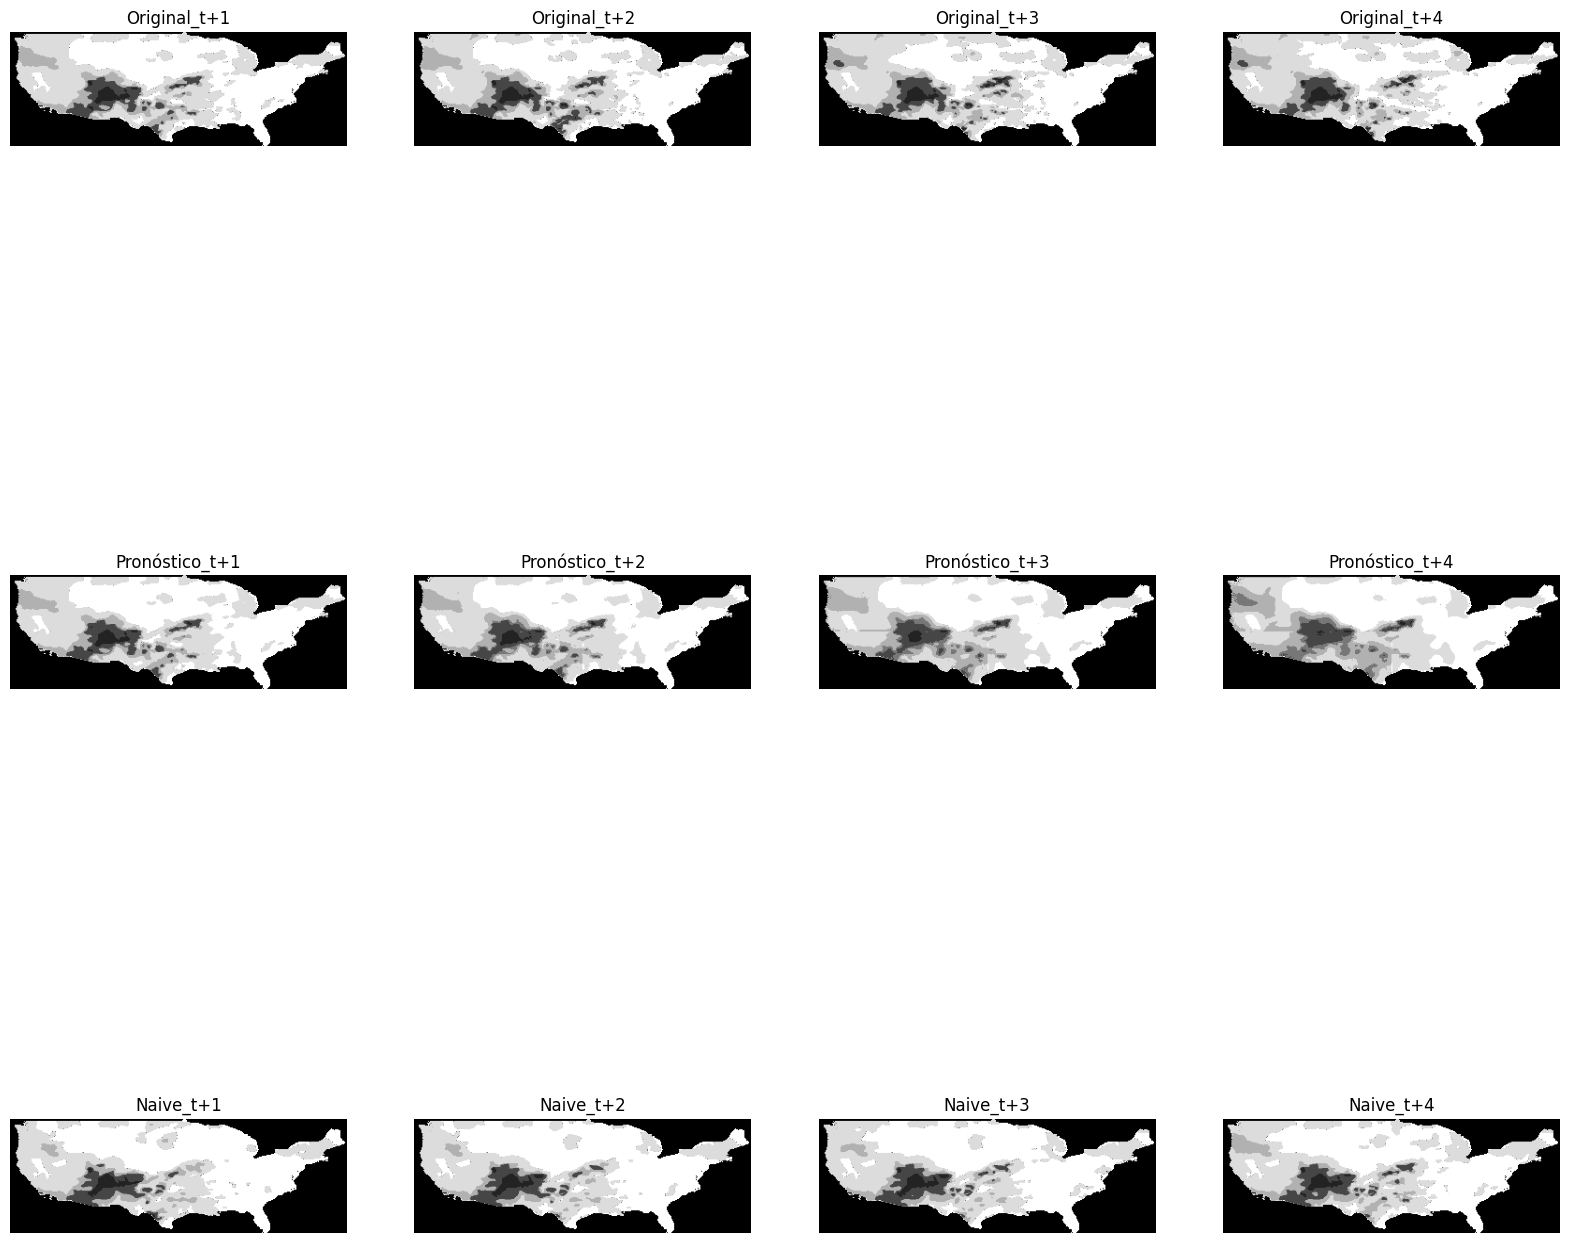

In [126]:

fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(y_test[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Original_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(new_merged_data[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Pronóstico_t+{}'.format(i+1))
for i in range(h):
    fig.add_subplot(r, c, ac)
    ac += 1
    plt.imshow(naive[pos,i], cmap='gray')
    plt.axis('off')
    plt.title('Naive_t+{}'.format(i+1))

plt.show()

In [127]:
#print 
print (f"lengeth y_test: {y_test.shape[0]}")
print (f"lengeth new_merged_data: {new_merged_data.shape[0]}")
print (f"h: {h}")
print (f"rows: {rows}")
print (f"cols: {cols}")

lengeth y_test: 367
lengeth new_merged_data: 367
h: 4
rows: 122
cols: 360


In [128]:
cm_f = np.zeros((l_clas, l_clas), dtype=np.uint64)
cm_n = np.zeros((l_clas, l_clas), dtype=np.uint64)
print(cm_f)

[[0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0]]


In [129]:
print("YTEST", y_test.shape)
print("h",h)
print("ROWS", rows)
print("COLS", cols)

YTEST (367, 4, 122, 360, 1)
h 4
ROWS 122
COLS 360


In [130]:
for e in range(y_test.shape[0]):
    for k in range(h):
        for i in range(rows):
            for j in range(cols):
                #print(f"e: {e}, k: {k}, i: {i}, j: {j}")
                pos1 = np.where(classes == y_test[e, k, i, j])[0][0]
                pos2 = np.where(classes == new_merged_data[e, k, i, j])[0][0]
                pos3 = np.where(classes == naive[e, k, i, j])[0][0]
                cm_f[pos1, pos2] += 1
                cm_n[pos1, pos3] += 1

print("Matriz de confusión de pronóstico")
print(cm_f)
print("Matriz de confusión de naive")
print(cm_n)

Matriz de confusión de pronóstico
[[25560508        0        0        0        0        5      331]
 [     378 17777300  1773457    44310     2136      534      238]
 [     200  1321969  9897285  1173210    58667    12129      503]
 [     464    44014   433607  2474078   519280   128340     2643]
 [    1396    24596    47753    71344   155537    42813     1858]
 [     858       57    13944   104933   276098  1658736    20891]
 [    1397       33      557     2162    14401   362244   447366]]
Matriz de confusión de naive
[[25560816        0        0        0        0        4       24]
 [       0 16913773  2511622   114041    54814     3776      327]
 [       0  2565049  8961253   798668    52035    80292     6666]
 [      20    86187   891407  2214743    62132   316853    31084]
 [       8    48167    55904    70204   121216    43825     5973]
 [       0     1021    80315   358722    47645  1459464   128350]
 [       0      156     2614    14466     4357   153493   653074]]


In [131]:
import pandas as pd

# Convert cm_f numpy array to pandas DataFrame
df_cm_f = pd.DataFrame(cm_f)

print(df_cm_f)

df_cm_n = pd.DataFrame(cm_n)

print(df_cm_n)

# Crear el DataFrame de la primera matriz de confusión como antes
df_cm_f = pd.DataFrame(cm_f, index=[f'True_{i}' for i in range(len(cm_f))],
                       columns=[f'Pred_{i}' for i in range(len(cm_f[0]))])

# Crear el DataFrame de la segunda matriz de confusión como antes
df_cm_n = pd.DataFrame(cm_n, index=[f'True_{i}' for i in range(len(cm_n))],
                       columns=[f'Pred_{i}' for i in range(len(cm_n[0]))])

# Calcular el desplazamiento necesario para la segunda matriz (longitud de la primera matriz + 2 por la columna vacía)
offset = df_cm_f.shape[1] + 2

# Crear un escritor de Excel
with pd.ExcelWriter("DroughtDatasetMask/CompletaXpartes/combined_confusion_matrices.xlsx") as writer:
    # Escribir la primera matriz en la hoja de cálculo empezando en la primera columna
    df_cm_f.to_excel(writer, startcol=0, index=True)
    
    # Escribir la segunda matriz en la hoja de cálculo con un desplazamiento
    df_cm_n.to_excel(writer, startcol=offset, index=True)

#with pd.ExcelWriter("DroughtDatasetMask/NPY61_180"+parte+"/cm_f_n.xlsx") as writer:
#    df_cm_f.to_excel(writer, sheet_name='cm_f')
#    df_cm_n.to_excel(writer, sheet_name='cm_n')



          0         1        2        3       4        5       6
0  25560508         0        0        0       0        5     331
1       378  17777300  1773457    44310    2136      534     238
2       200   1321969  9897285  1173210   58667    12129     503
3       464     44014   433607  2474078  519280   128340    2643
4      1396     24596    47753    71344  155537    42813    1858
5       858        57    13944   104933  276098  1658736   20891
6      1397        33      557     2162   14401   362244  447366
          0         1        2        3       4        5       6
0  25560816         0        0        0       0        4      24
1         0  16913773  2511622   114041   54814     3776     327
2         0   2565049  8961253   798668   52035    80292    6666
3        20     86187   891407  2214743   62132   316853   31084
4         8     48167    55904    70204  121216    43825    5973
5         0      1021    80315   358722   47645  1459464  128350
6         0       156    

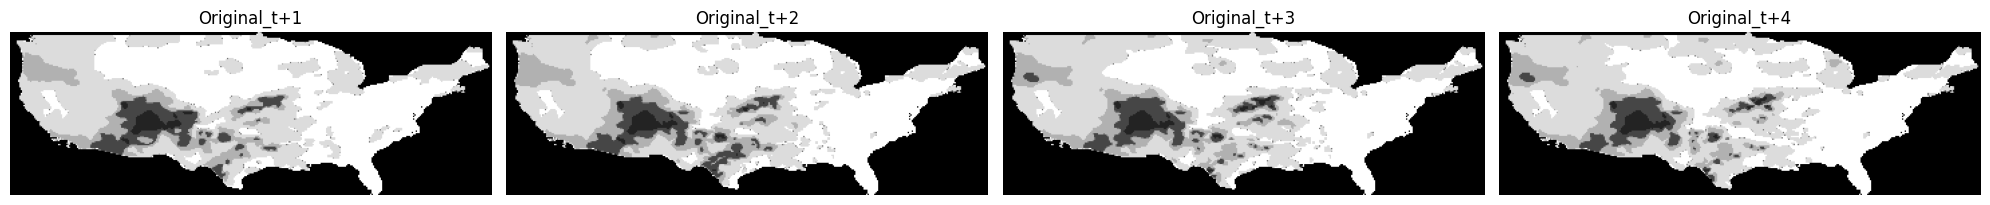

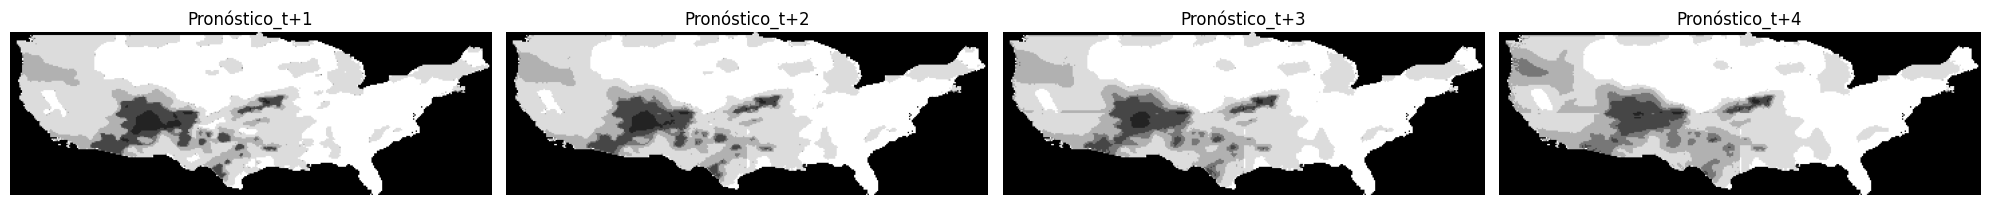

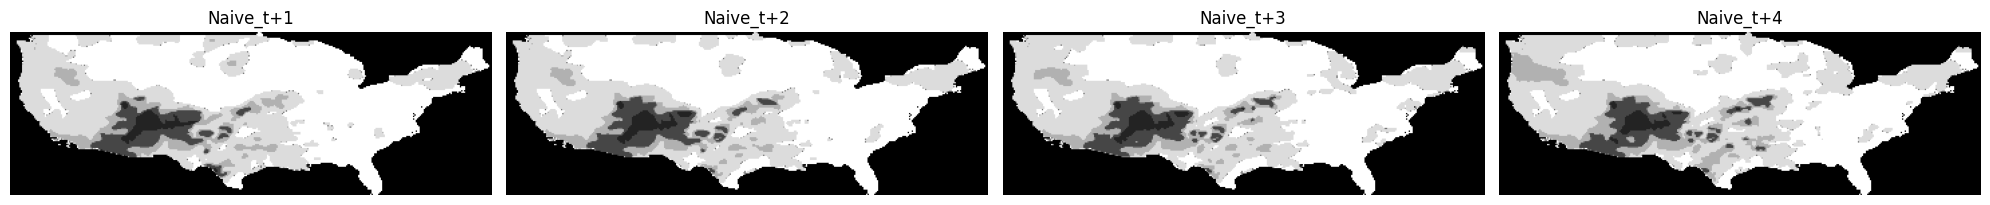

In [132]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(20,20))
r = 3
c = 4
ac = 1
pos = 100

for i in range(h):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(y_test[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Original_t+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()
fig = plt.figure(figsize=(20,20))
for i in range(h):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(new_merged_data[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Pronóstico_t+{}'.format(i+1))
    ac += 1
plt.tight_layout()
plt.show()
fig = plt.figure(figsize=(20,20))

for i in range(h):
    ax = fig.add_subplot(r, c, ac)
    ax.imshow(naive[pos,i], cmap='gray')
    ax.axis('off')
    ax.set_title('Naive_t+{}'.format(i+1))
    ac += 1

# Ajustar el espaciado entre subplots
plt.subplots_adjust(wspace=.1, hspace=0.05)  # Puedes disminuir estos valores si es necesario
plt.tight_layout()
plt.show()


## not working

In [133]:
#n_images = 5  # Define cuántas imágenes quieres mostrar
#fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
#for i in range(n_images):
#    for j in range(len(modelos)):
#        # Asegúrate de que cada imagen es una matriz 2D al usar squeeze()
#        axes[i].imshow(modelos[j][i].squeeze(), cmap='gray')
#        axes[i].set_title(f"Predicted Image {i+1}")
#        axes[i].axis('off')
#plt.tight_layout()
#plt.show()

In [134]:
#n_images = 5  # Define cuántas imágenes quieres mostrar
#fig, axes = plt.subplots(1, n_images, figsize=(20, 4))
#for i in range(n_images):
#    #Asegúrate de que cada imagen es una matriz 2D al usar squeeze()
#    print(f"Shape of predicted: {preds[i].shape}")
#    axes[i].imshow(preds[i].squeeze(), cmap='gray')
#    print(f"Shape of predicted image: {preds[i].shape}")
#    axes[i].set_title(f"Predicted Image {i+1}")
#    axes[i].axis('off')
#plt.tight_layout()
#plt.show()

In [135]:
print(range(len(x_test)))

range(0, 371)


In [136]:
#imagenInicial = np.random.choice(range(len(x_test)), size= 1)[0]
#print(imagenInicial)

In [137]:

#example = x_test[imagenInicial]
##frames = example[:4, ...]
##original_frames = example[4:, ...]
#print(example.shape)
##print(frames.shape)
##print(original_frames.shape)
#for _ in range(horizon):
#    print(example.shape)
#    new_prediction = model.predict(example.reshape(1,*example.shape[0:]))
#    example = np.concatenate((example[1:], new_prediction), axis=0)
#    print(f"example {example.shape}")
#predictions = example[:-3]
#print(predictions.shape)
## Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
#plt.imshow(predictions[0].squeeze(), cmap='gray')
#plt.title("First Predicted Image")
#plt.axis('off')
#plt.show()

In [138]:

#example = x_test[imagenInicial]
##frames = example[:4, ...]
##original_frames = example[4:, ...]
#print(example.shape)
##print(frames.shape)
##print(original_frames.shape)
#for _ in range(horizon):
#    print(example.shape)
#    new_prediction = model.predict(example.reshape(1,*example.shape[0:]))
#    example = np.concatenate((example[1:], new_prediction), axis=0)
#    print(f"example {example.shape}")
#predictions = example[:-3]
#print(predictions.shape)
## Selecciona la primera imagen y elimina la dimensión de canal singular con squeeze()
#
#for i in range(horizon):
#    plt.imshow(example[i].squeeze(), cmap='gray')
#    plt.title(f"{i+1} Predicted Image")
#    plt.axis('off')
#    plt.show()

In [139]:
#x_test = x_test[imagenInicial]
#for i in range(horizon):
#    plt.imshow(x_test[i].squeeze(), cmap='gray')
#    plt.title(f"{i+1} x_test Image")
#    plt.axis('off')
#    plt.show()